In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from FillBetween3D import fill_between_3d

In [2]:
df = pd.read_csv("./data/COMPOSED_norm.csv")
countries = list(df["Country"])
# 确保三个指标都是经过归一化处理的,且都转化为了正向指标，数值都在0-1内
Ves = ["HH","PUB","PRIV"]
V_0,V_1,V_2 = list(df[Ves[0]]),list(df[Ves[1]]),list(df[Ves[2]])


weights = np.array([0.4,0.25,0.35]) 
scale_func = np.vectorize(lambda x: x/max(weights)) # 根据权重调整三条棱的长度
scales = scale_func(weights)
scales

array([1.   , 0.625, 0.875])

In [3]:
def gravity(xes,yes,zes):
    # 得到三维空间中三角形的重心坐标
    return np.array([xes.sum()/3,yes.sum()/3,zes.sum()/3])

def newVertex_func(vertex,rootVertex,scale):
    # 根据两个点和缩放比来确定改变后一个点的位置
    # 在本程序中rootVertex一直为绝对顶点(见后方代码注释)
    # vertex: (x,y,z)
    res = []
    for d in range(3):
        d_value = vertex[d]
        root = rootVertex[d]
        res.append(root + (d_value - root) * scale)
    return res


def getXYZ(type:str,vertexes):
    # 返回一系列点的x或y或z坐标合集
    # type: "x", "y", "z"
    # vertexes: 一系列点的合集
    XYZ_dict = dict(x=0,y=1,z=2)
    XYZ = XYZ_dict[type]
    return np.array(list(map(lambda x:x[XYZ],vertexes)))

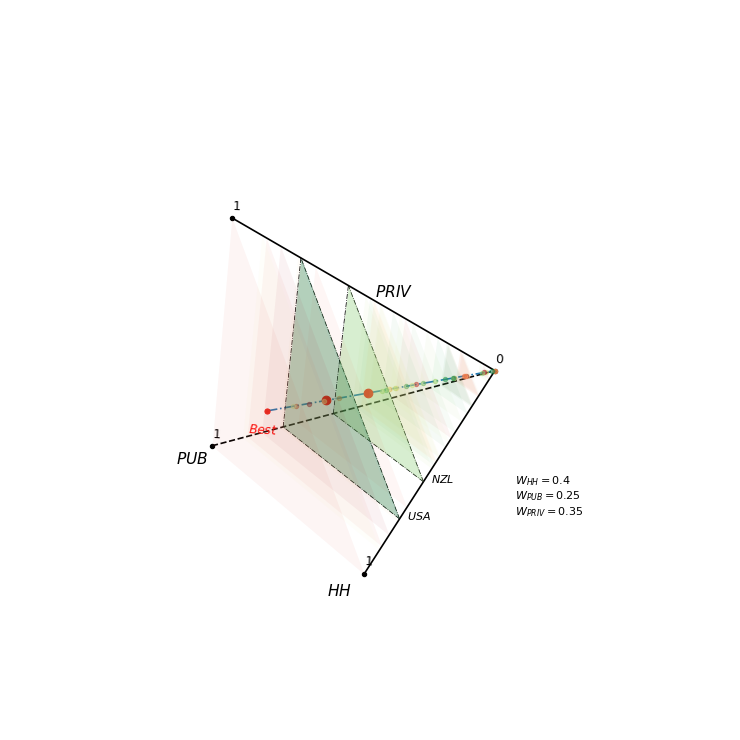

In [4]:
ax = plt.figure(figsize=(16,12),dpi=80).add_subplot(projection="3d")


# ========================
# ===== 绘制评价四面体 =====
edge_length = 10 # 最长边长
# 正四面体顶点
r_vertexes = np.array([
    [0,0,0],
    [0,edge_length,0],
    [0,edge_length/2,edge_length/2*np.sqrt(3)],
    [np.sqrt(6)*edge_length/3,edge_length/2,edge_length/2/np.sqrt(3)] # 以此为绝对顶点
])
# 得到评价四面体顶点
rootVertex = r_vertexes[3]
vertexes = np.array(list(map(lambda x: newVertex_func(x[1],rootVertex,scales[x[0]]),enumerate(r_vertexes[:3])))) # 得到除绝对顶点外的其他顶点经过缩放棱长的坐标
vertexes = np.append(vertexes,[rootVertex],axis=0)


Xes = getXYZ("x",vertexes=vertexes)
Yes = getXYZ("y",vertexes=vertexes)
Zes = getXYZ("z",vertexes=vertexes)

bottom_center = gravity(Xes[:3],Yes[:3],Zes[:3]) # 底面重心坐标

mainLinesStyle = ["-","--","-"]
for i in range(3): # 画出评价指标所代表的三条线段
    ax.plot(Xes[[i,3]],Yes[[i,3]],Zes[[i,3]],c="k",lw=1.5,ls=mainLinesStyle[i])
    # 标注指标名称
    if i == 2: # 画在轴中间
        ax.text(Xes[[i,3]].mean()+.2,Yes[[i,3]].mean(),Zes[[i,3]].mean(),f"${Ves[i]}$",c="k",fontsize=14,fontweight="semibold")
    else:
        ax.text(Xes[i]-1.2,Yes[i]-.3,Zes[i] -.2,f"${Ves[i]}$",c="k",fontsize=14,fontweight="semibold")
        

# 标注权重
ax.text2D(.7,.3,
f"$W_{{{Ves[0]}}}={weights[0]}$\n\
$W_{{{Ves[1]}}}={weights[1]}$\n\
$W_{{{Ves[2]}}}={weights[2]}$",
transform=ax.transAxes)




# 加入底面重心坐标
Xes = np.append(Xes,bottom_center[0])
Yes = np.append(Yes,bottom_center[1])
Zes = np.append(Zes,bottom_center[2])

zdir_set = (1,-2,1/18)
ax.plot(Xes[[4,3]],Yes[[4,3]],Zes[[4,3]],"-.") # 绝对顶点与底面重心的连线
ax.scatter([bottom_center[0]],[bottom_center[1]],[bottom_center[2]],c="red",s=20)
ax.text(bottom_center[0]-.5,bottom_center[1],bottom_center[2]-.5,"$Best$",zdir=zdir_set,color="red",fontsize=11) # 与最后的ax.view_init对应

for i in range(4): # 标注评价四面体四个顶点表示的占比(1或者0)
    label = "1" if i <= 2 else "0"
    ax.scatter([Xes[i]],[Yes[i]],[Zes[i]],c="k",s=15)
    ax.text(Xes[i]+.1,Yes[i]+.1,Zes[i]+.2,label,zdir=zdir_set,c="k",fontsize=11)






# ========================
# ===== 画上数据 =====
cmap = plt.get_cmap("RdYlGn")
colors = [cmap(i) for i in np.linspace(0,1,len(countries))]



selected_countries = ["USA","NZL"]
for index in range(len(countries)):
    is_selected = True if countries[index] in selected_countries else False
    section_alpha = .3 if is_selected else .05

    scales = [V_0,V_1,V_2]
    scale_index = 0
    newVertexes = []

    # 获得在每个指标上的坐标点
    for vertex in vertexes[:3]:
        newVertex = tuple(newVertex_func(vertex,rootVertex,scales[scale_index][index]))
        newVertexes.append(newVertex)

    Xes = getXYZ("x",newVertexes)
    Yes = getXYZ("y",newVertexes)
    Zes = getXYZ("z",newVertexes)

    # 截面颜色填充
    line1 = [Xes[[0,1]],Yes[[0,1]],Zes[[0,1]]]
    line2 = [Xes[[0,2]],Yes[[0,2]],Zes[[0,2]]]
    fill_between_3d(ax,*line1,*line2,mode=1,alpha=section_alpha,c=colors[index])

    # 截面描边
    if is_selected:
        for i in range(2):
            for j in range(i+1,3):
                ax.plot(Xes[[i,j]],Yes[[i,j]],Zes[[i,j]],c="k",ls="-.",lw=.7)
        # 加上文字备注
        ax.text(Xes[0]+.1,Yes[0] - .1,Zes[0],f"${countries[index]}$")


    P = gravity(Xes,Yes,Zes)
    color = "red" if is_selected else [colors[index]]
    size = 60 if is_selected else 15
    alpha = 1 if is_selected else .5
    ax.scatter([P[0]],[P[1]],[P[2]],c=color,s=size,alpha=alpha)


    


# 第一个参数为10时, 第二个参数建议数值 -115(接近正侧面),-132
ax.view_init(10,-132) # 当-115时建议将for循环头部的section_alpha改成默认为.1,当-132时建议.05

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_axis_off() # 隐藏坐标轴
plt.savefig("3_var.png",dpi=300)